In [ ]:
# we eliminate these features=>
#cusomer_ID, churn (not numeric)
#days_since_last_purches(leakage)
#product_review_score(high overlap with satisfaction_score)


In [38]:
#Model A (full) : with days_since_last purchase
#model B (no leak check): without days_since_last_purchase
#model B
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier


merged_df= pd.read_csv('../archive/merged_churn.csv')

y= merged_df['churned'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})
X = merged_df.select_dtypes(include=['number']).drop(columns=['Customer_ID', 
                                                              'days_since_last_purchase',
                                                              'product_review_score_avg'], 
                                                     errors='ignore')


if 'churned' in X.columns:
    X = X.drop(columns=['churned'])

    
#splitting train and test set
X_train,X_test,y_train,y_test= train_test_split(X,y,
                                                random_state=104,
                                                test_size=0.2,
                                                stratify=y)
# printing out train and test sets

print('X_train : ')
print(X_train.head())
print('')
print('X_test : ')
print(X_test.head())
print('')
print('y_train : ')
print(y_train.head())
print('')
print('y_test : ')
print(y_test.head())

X_train : 
      account_age_months  avg_order_value  total_orders  discount_usage_rate  \
5630                   5            70.46             2                0.154   
968                   41           159.93             1                0.463   
1726                  26            75.80             7                0.664   
1480                  60            52.66            16                0.243   
478                   32           156.76            17                0.223   

      return_rate  customer_support_tickets  browsing_frequency_per_week  \
5630       0.0328                         1                          2.9   
968        0.0576                         0                          2.7   
1726       0.0848                         0                          5.6   
1480       0.0216                         2                          0.0   
478        0.0488                         0                          0.9   

      cart_abandonment_rate  engagement_score  sati

In [39]:
# Run the baseline model B
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

#initialize the dummy model 
baseline_model= DummyClassifier(strategy='most_frequent')

#train it (it just learns which class is most common)
baseline_model.fit(X_train, y_train)

#Make preictions
y_pred= baseline_model.predict(X_test)

print('----baseline model performance----')
print(classification_report(y_test,y_pred, zero_division=0))


----baseline model performance----
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      1014
           1       0.00      0.00      0.00       186

    accuracy                           0.84      1200
   macro avg       0.42      0.50      0.46      1200
weighted avg       0.71      0.84      0.77      1200



In [40]:
#logistic regretion MODEL B
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


y= merged_df['churned'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})
X = merged_df.select_dtypes(include=['number']).drop(columns=['Customer_ID', 
                                                              'days_since_last_purchase',
                                                              'product_review_score_avg'], 
                                                     errors='ignore')



# Scale the numerical data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

clf = LogisticRegression(max_iter=10000, random_state=0)
clf.fit(X_train_scaled, y_train)

acc = accuracy_score(y_test, clf.predict(X_test)) * 100
print(f"Logistic Regression model accuracy: {acc:.2f}%")

# 1. Get the model's predictions
y_pred = clf.predict(X_test_scaled)

# 2. Generate the report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Logistic Regression model accuracy: 84.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1014
           1       0.91      0.85      0.88       186

    accuracy                           0.96      1200
   macro avg       0.94      0.92      0.93      1200
weighted avg       0.96      0.96      0.96      1200



Recall: 0.8118279569892473
F1: 0.8703170028818443
Precision: 0.937888198757764


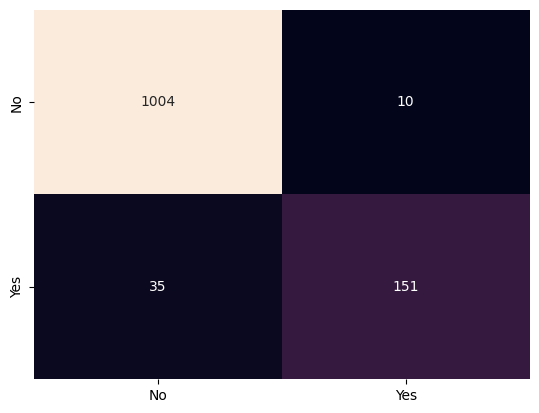

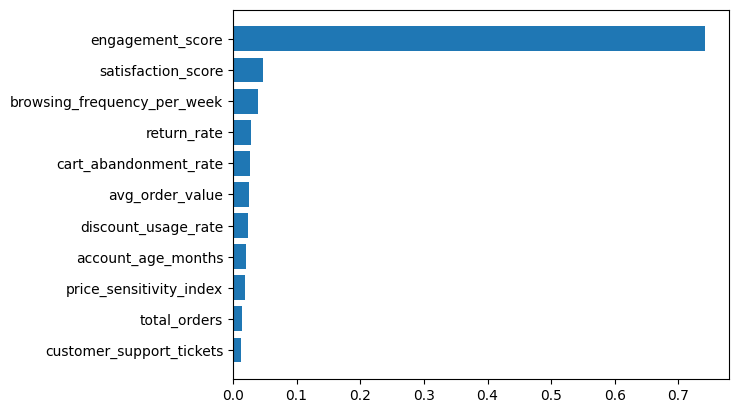

In [60]:
#random forest model B
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Target (make sure it’s 0/1)
y = merged_df['churned'].astype(str).str.lower().map({'yes': 1, 'no': 0})

# Features: numeric only + drop columns (Customer_ID will already be non-numeric usually)
X_df = merged_df.select_dtypes(include=['number']).drop(
    columns=['Customer_ID' , 'days_since_last_purchase', 'product_review_score_avg'],
    errors='ignore'
)

# remove rows where y is NaN (if any unexpected labels)
mask = y.notna()
X_df = X_df.loc[mask]
y = y.loc[mask].astype(int)

# Split (IMPORTANT: split using X_df, not X = merged_df.iloc[:, :-1].values)
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=104, stratify=y
)


# Model
clf = RandomForestClassifier(n_estimators=100, random_state=104)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]

threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)


print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.show()

# Feature importances (use X_df columns)
importances = clf.feature_importances_
idx = importances.argsort()
plt.barh(X_df.columns[idx], importances[idx])
plt.show()

In [42]:
#Model A (full) : with days_since_last purchase
#model B (no leak check): without days_since_last_purchase
#model A
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier


merged_df= pd.read_csv('../archive/merged_churn.csv')

y= merged_df['churned'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})
X = merged_df.select_dtypes(include=['number']).drop(columns=['Customer_ID', 
                                                              
                                                              'product_review_score_avg'], 
                                                     errors='ignore')


if 'churned' in X.columns:
    X = X.drop(columns=['churned'])

    
#splitting train and test set
X_train,X_test,y_train,y_test= train_test_split(X,y,
                                                random_state=104,
                                                test_size=0.2,
                                                stratify=y)
# printing out train and test sets

print('X_train : ')
print(X_train.head())
print('')
print('X_test : ')
print(X_test.head())
print('')
print('y_train : ')
print(y_train.head())
print('')
print('y_test : ')
print(y_test.head())

X_train : 
      account_age_months  avg_order_value  total_orders  \
5630                   5            70.46             2   
968                   41           159.93             1   
1726                  26            75.80             7   
1480                  60            52.66            16   
478                   32           156.76            17   

      days_since_last_purchase  discount_usage_rate  return_rate  \
5630                        48                0.154       0.0328   
968                          7                0.463       0.0576   
1726                        36                0.664       0.0848   
1480                        12                0.243       0.0216   
478                          9                0.223       0.0488   

      customer_support_tickets  browsing_frequency_per_week  \
5630                         1                          2.9   
968                          0                          2.7   
1726                         0      

In [43]:
# Run the baseline model A
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

#initialize the dummy model 
baseline_model= DummyClassifier(strategy='most_frequent')

#train it (it just learns which class is most common)
baseline_model.fit(X_train, y_train)

#Make preictions
y_pred= baseline_model.predict(X_test)

print('----baseline model performance----')
print(classification_report(y_test,y_pred, zero_division=0))


----baseline model performance----
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      1014
           1       0.00      0.00      0.00       186

    accuracy                           0.84      1200
   macro avg       0.42      0.50      0.46      1200
weighted avg       0.71      0.84      0.77      1200



In [44]:
#logistic regretion MODEL A
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


y= merged_df['churned'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})
X = merged_df.select_dtypes(include=['number']).drop(columns=['Customer_ID', 
                                                              'product_review_score_avg'], 
                                                     errors='ignore')



# Scale the numerical data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

clf = LogisticRegression(max_iter=10000, random_state=0)
clf.fit(X_train_scaled, y_train)

acc = accuracy_score(y_test, clf.predict(X_test)) * 100
print(f"Logistic Regression model accuracy: {acc:.2f}%")

# 1. Get the model's predictions
y_pred = clf.predict(X_test_scaled)

# 2. Generate the report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Logistic Regression model accuracy: 55.42%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1014
           1       0.91      0.85      0.88       186

    accuracy                           0.96      1200
   macro avg       0.94      0.92      0.93      1200
weighted avg       0.96      0.96      0.96      1200



Recall: 0.8118279569892473
F1: 0.8653295128939829
Precision: 0.9263803680981595


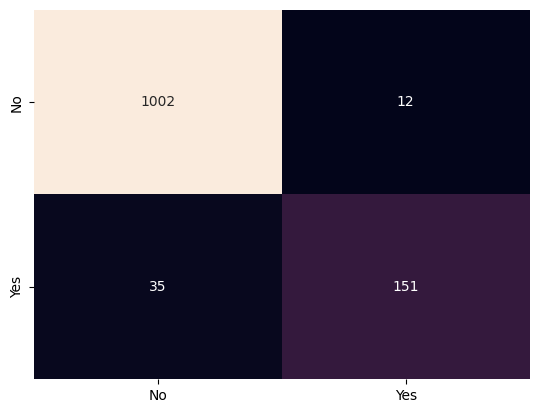

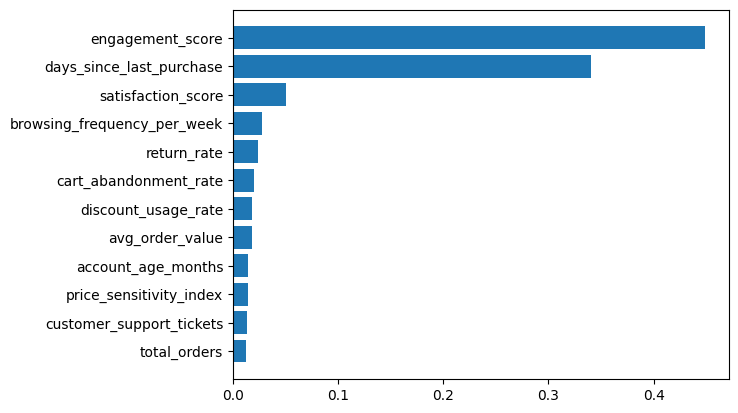

In [59]:
#Random forest MODEL A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Target (make sure it’s 0/1)
y = merged_df['churned'].astype(str).str.lower().map({'yes': 1, 'no': 0})

# Features: numeric only + drop columns (Customer_ID will already be non-numeric usually)
X_df = merged_df.select_dtypes(include=['number']).drop(
    columns=['Customer_ID', 'product_review_score_avg'],
    errors='ignore'
)

# remove rows where y is NaN (if any unexpected labels)
mask = y.notna()
X_df = X_df.loc[mask]
y = y.loc[mask].astype(int)

# Split (IMPORTANT: split using X_df, not X = merged_df.iloc[:, :-1].values)
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=104, stratify=y
)


# Model
clf = RandomForestClassifier(n_estimators=100, random_state=104)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]

threshold = 0.4

y_pred = (y_proba >= threshold).astype(int)


print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.show()

# Feature importances (use X_df columns)
importances = clf.feature_importances_
idx = importances.argsort()
plt.barh(X_df.columns[idx], importances[idx])
plt.show()

In [46]:
# find the best threshold 
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score

thresholds = np.arange(0.10, 0.61, 0.05)

best = {"thr": None, "f1": -1, "recall": None, "precision": None}

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr)
    rec = recall_score(y_test, y_pred_thr)
    prec = precision_score(y_test, y_pred_thr, zero_division=0)

    # اگر هدفت maximize کردن F1 هست:
    if f1 > best["f1"]:
        best = {"thr": thr, "f1": f1, "recall": rec, "precision": prec}

print("BEST THRESHOLD:", best)

BEST THRESHOLD: {'thr': 0.5000000000000001, 'f1': 0.8857938718662952, 'recall': 0.8548387096774194, 'precision': 0.9190751445086706}


In [61]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

for thr in np.arange(0.2, 0.71, 0.05):
    y_pred_thr = (y_proba >= thr).astype(int)
    print(thr,
          "rec:", round(recall_score(y_test, y_pred_thr), 3),
          "prec:", round(precision_score(y_test, y_pred_thr), 3),
          "f1:", round(f1_score(y_test, y_pred_thr), 3))

0.2 rec: 0.957 prec: 0.774 f1: 0.856
0.25 rec: 0.941 prec: 0.81 f1: 0.871
0.3 rec: 0.919 prec: 0.826 f1: 0.87
0.35 rec: 0.903 prec: 0.862 f1: 0.882
0.39999999999999997 rec: 0.892 prec: 0.874 f1: 0.883
0.44999999999999996 rec: 0.855 prec: 0.893 f1: 0.874
0.49999999999999994 rec: 0.844 prec: 0.908 f1: 0.875
0.5499999999999999 rec: 0.828 prec: 0.928 f1: 0.875
0.5999999999999999 rec: 0.812 prec: 0.938 f1: 0.87
0.6499999999999999 rec: 0.769 prec: 0.947 f1: 0.849
0.7 rec: 0.753 prec: 0.952 f1: 0.841
